Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.linear_model import LogisticRegressionCV
import xgboost as xgb 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from math import log

%matplotlib inline

Importing the dataset

In [2]:
train_values = pd.read_csv('./dataset/train_values.csv')
train_labels = pd.read_csv('./dataset/train_labels.csv')
test_values = pd.read_csv('./dataset/test_values.csv')
submission = pd.read_csv('./dataset/submission_format.csv')

Understanding the dataset

In [3]:
train_values.shape

(260601, 39)

In [4]:
test_values.shape

(86868, 39)

In [5]:
train_values.head().transpose()

,0,1,2,3,4
building_id,802906,28830,94947,590882,201944
geo_level_1_id,6,8,21,22,11
geo_level_2_id,487,900,363,418,131
geo_level_3_id,12198,2812,8973,10694,1488
count_floors_pre_eq,2,2,2,2,3
age,30,10,10,10,30
area_percentage,6,8,5,6,8
height_percentage,5,7,5,5,9
land_surface_condition,t,o,t,t,t
foundation_type,r,r,r,r,r


In [6]:
train_values.dtypes

building_id                                int64
geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_c

Dataset Preprocessing

Check for missing, NaN values

In [7]:
train_values.isnull().values.any()
train_labels.isnull().values.any()

#The dataset contains no missing values.

False

Check for Outliers

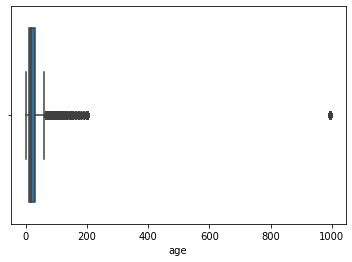

In [8]:
ax = sns.boxplot(x=train_values["age"])

Even though the boxplot for the age of the buildings shows outliers, according to other sources, the buildings in Nepal actually date back to several thousands of years.

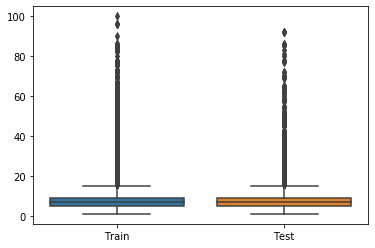

In [9]:
data = pd.DataFrame({ 'Train': train_values["area_percentage"], 'Test' : test_values["area_percentage"]})
ax = sns.boxplot(data=data)

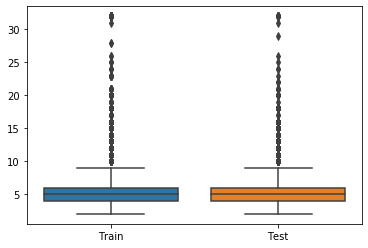

In [10]:
data = pd.DataFrame({ 'Train': train_values["height_percentage"], 'Test' : test_values["height_percentage"]})
ax = sns.boxplot(data=data)

We cannot eliminate all the outliers in the train data as the test data also contains outliers similar to the train data.

Converting categorical variables into Numeric form

In [11]:
#Columns with categorical data
num_cols = train_values._get_numeric_data().columns
categories = list(set(train_values.columns) - set(num_cols))
categories

['roof_type',
 'other_floor_type',
 'legal_ownership_status',
 'position',
 'plan_configuration',
 'foundation_type',
 'ground_floor_type',
 'land_surface_condition']

In [12]:
for i in categories:
    print(i, set(train_values[i]))

roof_type {'n', 'q', 'x'}
other_floor_type {'x', 'q', 's', 'j'}
legal_ownership_status {'w', 'a', 'v', 'r'}
position {'j', 's', 't', 'o'}
plan_configuration {'n', 'm', 'f', 'a', 'o', 'u', 's', 'c', 'q', 'd'}
foundation_type {'i', 'h', 'r', 'w', 'u'}
ground_floor_type {'x', 'm', 'f', 'v', 'z'}
land_surface_condition {'n', 't', 'o'}


In [13]:
#One hot Encodings
train_values_new = pd.get_dummies(train_values)
test_values_new = pd.get_dummies(test_values)

print('Training dataset :',train_values_new.shape)
print()
print('Test dataset :',test_values_new.shape)

Training dataset : (260601, 69)

Test dataset : (86868, 69)


In [14]:
#Factors Method

#Preparing Training Data
df = train_values
for col_name in categories:
        df[col_name]= df[col_name].astype('category')
        df[col_name] = df[col_name].cat.codes
print("Train Data Shape: ", df.shape)

#Preparing Test Data
df_test = test_values
for col_name in categories:
        df_test[col_name]= df_test[col_name].astype('category')
        df_test[col_name] = df_test[col_name].cat.codes
print("Test Data Shape: ", df_test.shape)

Train Data Shape:  (260601, 39)
Test Data Shape:  (86868, 39)


Basic Summary Statistic

In [15]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
building_id,260601.0,525675.482773,304544.999032,4.0,261190.0,525757.0,789762.0,1052934.0
geo_level_1_id,260601.0,13.900353,8.033617,0.0,7.0,12.0,21.0,30.0
geo_level_2_id,260601.0,701.074685,412.710734,0.0,350.0,702.0,1050.0,1427.0
geo_level_3_id,260601.0,6257.876148,3646.369645,0.0,3073.0,6270.0,9412.0,12567.0
count_floors_pre_eq,260601.0,2.129723,0.727665,1.0,2.0,2.0,2.0,9.0
age,260601.0,26.535029,73.565937,0.0,10.0,15.0,30.0,995.0
area_percentage,260601.0,8.018051,4.392231,1.0,5.0,7.0,9.0,100.0
height_percentage,260601.0,5.434365,1.918418,2.0,4.0,5.0,6.0,32.0
land_surface_condition,260601.0,1.695427,0.696040,0.0,2.0,2.0,2.0,2.0
foundation_type,260601.0,2.119036,0.579154,0.0,2.0,2.0,2.0,4.0


Exploratory Data Analysis

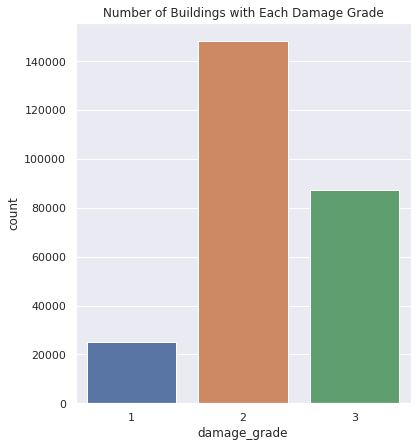

2    148259
3     87218
1     25124
Name: damage_grade, dtype: int64

It can be clearly seen that most (about 56.89%) of the buildings have been moderately (damage_grade = 2) damaged by the earthquake


In [16]:
# On plotting a bar plot for each damage grade, we observe that the data is imbalanced.
# Countplot of 'damage_grade' column ( Counts of different damage grades )

sns.set(rc={'figure.figsize':(6,7)})
sns.countplot(train_labels['damage_grade']).set_title("Number of Buildings with Each Damage Grade")
plt.show()
damage_grade_count = train_labels['damage_grade'].value_counts()
print(damage_grade_count)
print()
print('It can be clearly seen that most (about %.2f%%) of the buildings have been moderately (damage_grade = 2) damaged by the earthquake' 
      %(round(damage_grade_count[2]/sum(damage_grade_count)*100,2)))

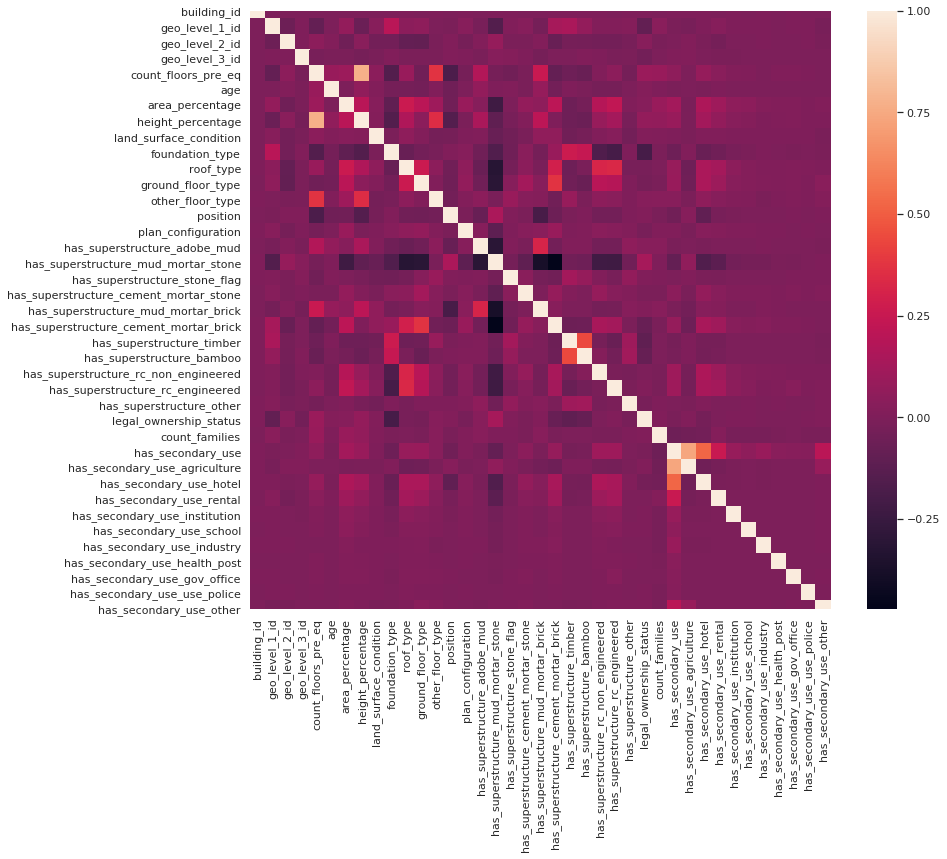

In [17]:
plt.figure(figsize=(13,11))
data_corr = train_values.corr()
sns.heatmap(data_corr)
plt.show();

The below plot shows relationship between a few selected columns


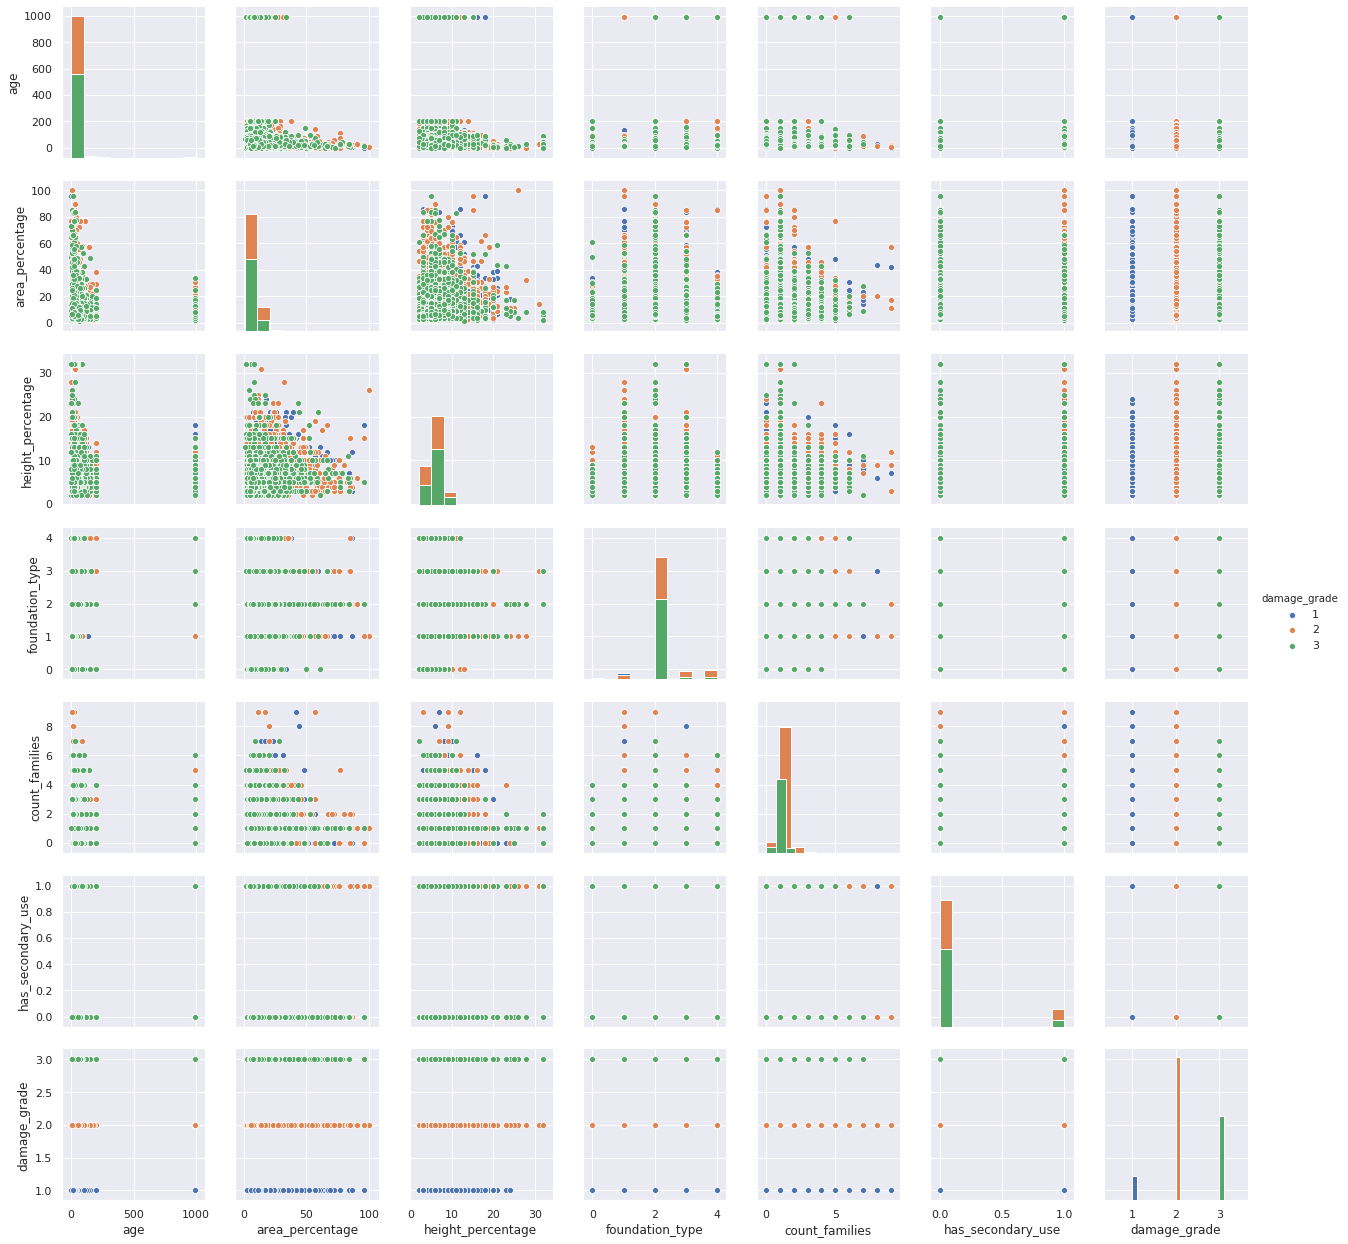

In [18]:
# Pairplot of a few selected columns

print('The below plot shows relationship between a few selected columns')
df_merged = train_values.merge(train_labels)
selected_features = ['age',
                 'area_percentage',
               'height_percentage',
               'foundation_type',
               'count_families',
               'has_secondary_use',
                'damage_grade']

df_merged = df_merged[selected_features]

sns.pairplot(data = df_merged, hue = "damage_grade", diag_kind = "hist", kind = "scatter")
plt.show()

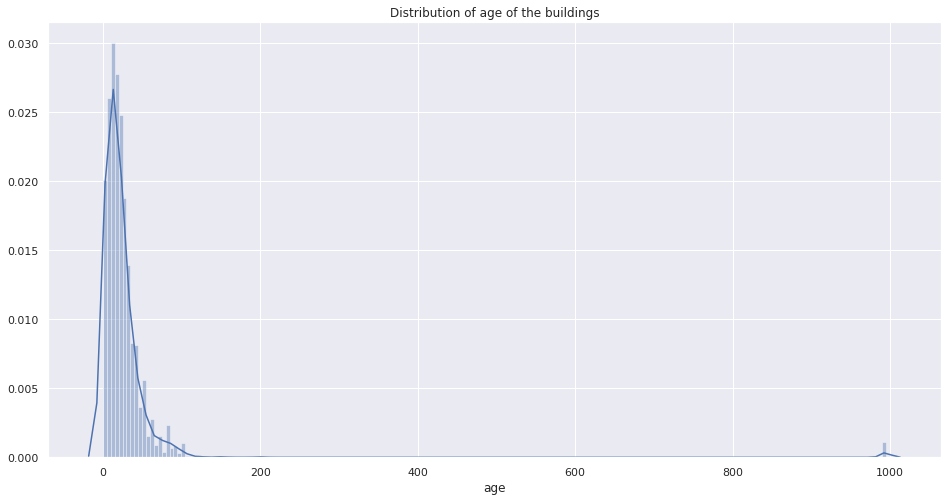

Number of zeros(in age column):  26041
26k zeros can imply two things, all those building were built in the past year(pretty unlikely) or that there were some unknown values and they have been filled with 0

From the above histogram we can infer that most of the buildings that were destroyed during the earthquake were new or recently build


In [19]:
# Histogram of 'age' column ( Distribution of age of the buildings )

sns.set(rc={'figure.figsize':(16,8)})
sns.distplot(df.age, bins = 200, kde = True)
plt.title('Distribution of age of the buildings')
plt.show()

# log transformation applied on age column for values greater than 0
# sns.set(rc={'figure.figsize':(16,8)})
# sns.distplot(df.age[df.age>0].apply(log), bins = 40, kde = True)
# plt.title('Distribution of age of the buildings after log transformation')
# plt.show()

num_of_zeros = df['age'].to_list().count(0)
print('Number of zeros(in age column): ',num_of_zeros)
print('26k zeros can imply two things, all those building were built in the past year(pretty unlikely) or that there were some unknown values and they have been filled with 0')
print()
print('From the above histogram we can infer that most of the buildings that were destroyed during the earthquake were new or recently build')

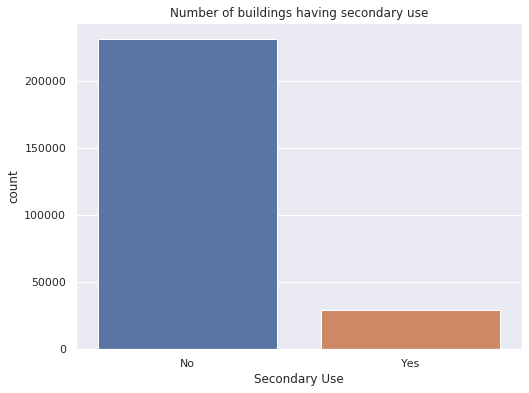

0    231445
1     29156
Name: has_secondary_use, dtype: int64

Only a small percentage (11.19%) of the buildings had a secondary use


In [20]:
# Countplot of 'has_secondary_use' column ( Number of buildings having secondary use )

sns.set(rc={'figure.figsize':(8,6)})
sns.countplot(df['has_secondary_use'])
plt.title('Number of buildings having secondary use')
plt.xlabel('Secondary Use')
plt.xticks(np.arange(2), ('No', 'Yes'))
plt.show()
secondary_use_count = df['has_secondary_use'].value_counts()
print(secondary_use_count)
print()
print('Only a small percentage (%.2f%%) of the buildings had a secondary use' %(round(secondary_use_count[1]/len(df.has_secondary_use)*100,2)))

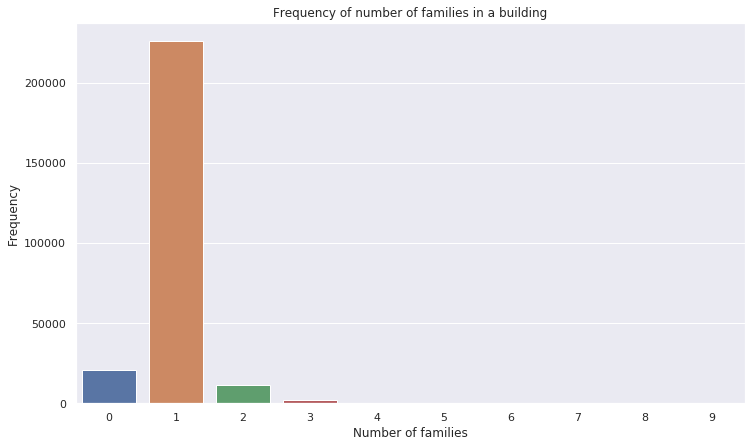

1    226115
0     20862
2     11294
3      1802
4       389
5       104
6        22
7         7
9         4
8         2
Name: count_families, dtype: int64

Majority of the buildings (about 86.77%) had only 1 family living in them


In [21]:
# Countplot for 'count_families' column ( frequency of number of families )

sns.set(rc={'figure.figsize':(12,7)})
sns.countplot(df.count_families)
plt.title('Frequency of number of families in a building')
plt.xlabel('Number of families')
plt.ylabel('Frequency')
plt.show()
families_count = df['count_families'].value_counts()
print(families_count)
print()
print('Majority of the buildings (about %.2f%%) had only 1 family living in them' %(round((families_count[1]/len(df.count_families))*100,2)))

area_percentage represents the normalized area of the building footprint


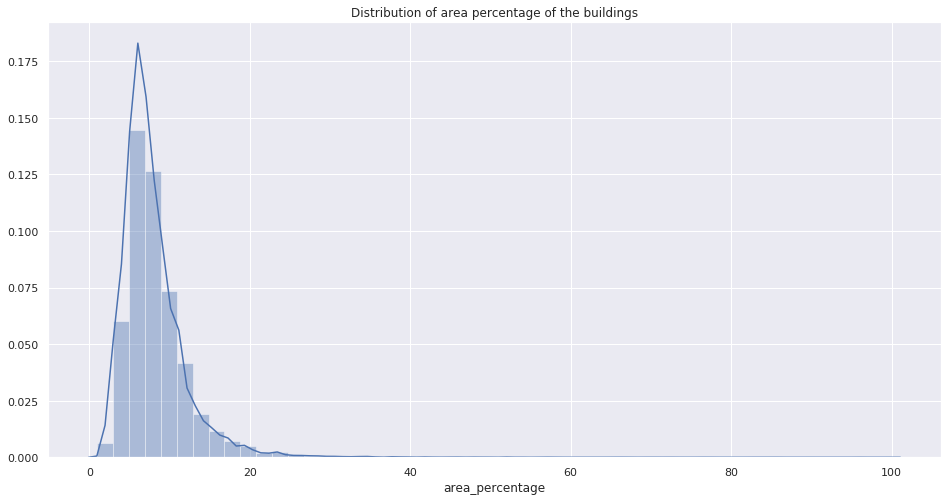

The above distribution of area percentage shows it is positively(right) skewed
So, we can use log transformation to make the distribution more normal



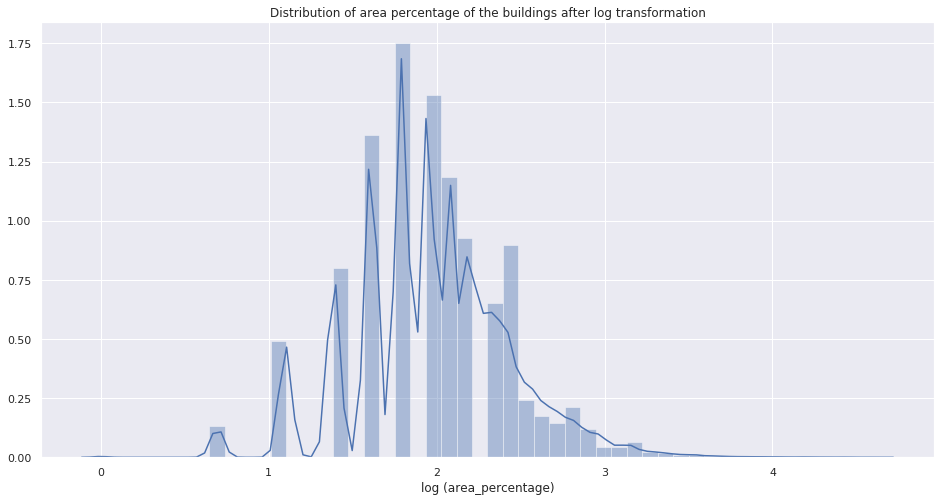

In [22]:
# Histogram of 'area_percentage' column   ( Distribution of area percentage of the buildings )

print('area_percentage represents the normalized area of the building footprint')
sns.set(rc={'figure.figsize':(16,8)})
sns.distplot(df.area_percentage)
plt.title('Distribution of area percentage of the buildings')
plt.show()
print('The above distribution of area percentage shows it is positively(right) skewed')
print('So, we can use log transformation to make the distribution more normal')
print()
sns.distplot(df.area_percentage.apply(log))
plt.title('Distribution of area percentage of the buildings after log transformation')
plt.xlabel('log (area_percentage)')
plt.show()


height_percentage represents the normalized height of the building footprint


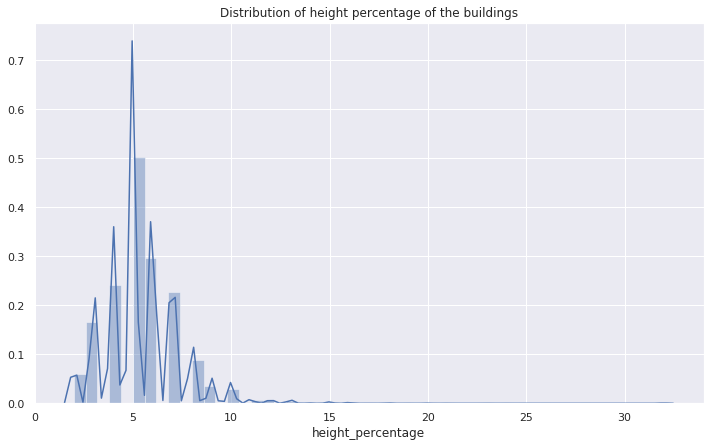

In [23]:
# Histogram of 'height_percentage' column  ( Distribution of height percentage of the buildings )

print('height_percentage represents the normalized height of the building footprint')
sns.set(rc={'figure.figsize':(12,7)})
sns.distplot(df.height_percentage)
plt.title('Distribution of height percentage of the buildings')
plt.show()


In [24]:
# for i in df.columns:
#     #df.hist(column=i, bins=10)
#     sns.distplot(df[i])
#     plt.show()

In [25]:
#sns.pairplot(df);

Basic Models:
1. Logistic Regression
2. Random Forest

In [26]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(df, train_labels['damage_grade'], test_size=0.3) # 70% training and 30% test

In [27]:
def print_confusion_matrix(y_train, y_pred):
    cm = confusion_matrix(y_train, y_pred)
    df_cm = pd.DataFrame(cm, range(3), range(3))
    df_cm = pd.DataFrame(cm, columns=np.unique(y_train), index = np.unique(y_train))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    ax = sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
    ax.get_ylim()
    ax.set_ylim(3.0, 0)

Logistic Regression

In [28]:
clf = LogisticRegression(random_state=1, solver='lbfgs', 
                         multi_class='multinomial').fit(X_train, y_train)

In [29]:
predicted_labels = clf.predict(X_test)

clf.score(X_test, y_test)

0.5694222381397015

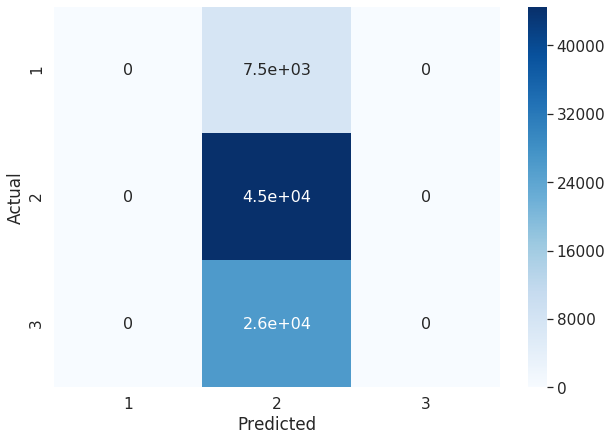

In [30]:
print_confusion_matrix(y_test, predicted_labels)

Random Forest

In [31]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)

pred_labels = clf.predict(X_test)

In [32]:
# Model Accuracy
print("Accuracy of Random Forest: ",clf.score(X_test, y_test))

Accuracy of Random Forest:  0.72222151162


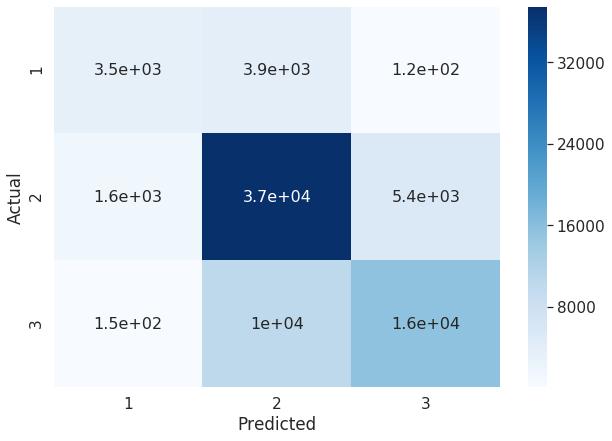

In [33]:
print_confusion_matrix(y_test, pred_labels)